This notebook demonstrates the evaluation and monitoring of the robustness of a machine learning model on continuous input data by calculating the `Adversarial Accuracy` metric as a function of the size of adversarial perturbations, created by adversarial attacks, added to the input data. 
Adversarial Accuracy is defined as the classification accuracy of the model on adversarial examples, which are minimally perturbed versions of the original samples that are usually found across the nearest decision boundary of the model. Especially in images, these perturbations are hardly recognisable and look like small noise to the human eye but result in misclassification by the model. The same definitions, interpretations and tools are valid for tabular/structured data, but images are nicer to visualise in a notebook. <br>

This notebook uses two models, a normally trained default model and an adversarially trained model, for classification of the MNIST dataset of images showing hand-written digits. We evaluate the base robustness of the default model on the training and test datasets by computing the `adversarial_accuracy` metric as a function of input perturbation size (also called adversarial accuracy curve), using a white-box evasion attack called Projected Gradient Descent (PGD) of the Adversarial Robustness Toolbox (ART) and the ibm_metrics_plugin python library. <br>

We repeat this evaluation on the robust model that has been adversarially trained to increase its robustness and compare its adversarial accuracy curve with the one previously obtained on the default model. This step allows us to demonstrate the interpretations and utility of adversarial accuracy curves in selecting the most robust model and to discuss the metrics which should be continuously monitored in deployment to track changes in robustness over time.

In the second half of the notebook, we repeat these evaluations for the default and robust models, using a `black-box evasion` attack that does not require a differentiable model, which means it can work with the model's scoring endpoint alone. The black-box-attack is minimising the required perturbations which means it tries to find the shortest distance of a sample to the model's decision boundary. Using a histogram method, we demonstrate how to transfer these observed minimised perturbation sizes into metrics that can be continuously monitored.

Finally, we will demonstrate an additional benefit of applying adversarial black-box evasion attacks to each payload of a deployed model. By applying the attack to batches of benign and adversarial examples to obtain their respective adversarial accuracy curves, we demonstrate how these metrics help to `detect adversarial examples` (samples that are very close to a decision boundary of the model) or to `detect drift` in the input data (by monitoring the change of the payloads' distribution of distances to the decision boundary).


## SetUp

### Installing required libraries

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install adversarial-robustness-toolbox
!pip install --upgrade --user ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade --user ibm_metrics_plugin --no-cache | tail -n 1
!pip install numpy==1.23.5
!pip install --upgrade pyspark==3.3.1 | tail -n 1
!pip install tensorflow
!pip install wget

### Action: Restart the Kernel!

In [9]:
import numpy as np
import tensorflow as tf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adadelta
from ibm_watson_openscale import APIClient as OpenScaleAPIClient
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator, CloudPakForDataAuthenticator
from ibm_watson_openscale.supporting_classes.enums import TargetTypes,ServiceTypes
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import *

In [10]:
tf_version = [int(v) for v in tf.__version__.split(".")]
if tf_version[0] == 2 and tf_version[1] >= 3:
    tf.compat.v1.disable_eager_execution()
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
else:
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

### Load the mnist training data

In [11]:
# pre define the variables
batch_size = 128
num_classes = 10
epochs = 6

In [12]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras_backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [13]:
# one hot encode target values
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### Create MNIST model

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [15]:
# Fit the model on training data
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Train on 60000 samples
Epoch 1/6
60000/60000 [==============================] - 31s 519us/sample - loss: 2.2738 - accuracy: 0.1533
Epoch 2/6
60000/60000 [==============================] - 32s 533us/sample - loss: 2.2049 - accuracy: 0.2690
Epoch 3/6
60000/60000 [==============================] - 32s 541us/sample - loss: 2.1179 - accuracy: 0.3745
Epoch 4/6
60000/60000 [==============================] - 32s 542us/sample - loss: 2.0046 - accuracy: 0.4603
Epoch 5/6
60000/60000 [==============================] - 35s 576us/sample - loss: 1.8594 - accuracy: 0.5282
Epoch 6/6
60000/60000 [==============================] - 37s 616us/sample - loss: 1.6955 - accuracy: 0.5786


We will now see a small demonstration of how an adversarial example can change the model's prediction. First, we will plot the first image in the training data and check the model's prediction for this data point. Then, we will create an adversarial example for the same image in the training data. This adversarial image will look exactly similar to the original image in the training data. But the model will predict this as a different image.

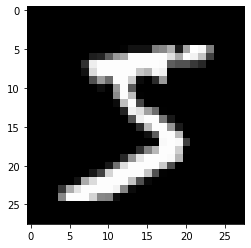

Model's Prediction for the input image:3


In [16]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
img = np.array(x_train[0], dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

print("Model's Prediction for the input image:" + str(np.argmax(model.predict(x=x_train[:1]))))

In [17]:
def scoring_fn(x):
    res = to_categorical(np.argmax(model.predict(x), axis=1), 10)
    return res

In [18]:
from art.attacks.evasion.hop_skip_jump import HopSkipJump
from art.estimators.classification import BlackBoxClassifier

# Create art classifier, which is a wrapper on top of the original model
art_classifier = BlackBoxClassifier(predict_fn=scoring_fn, input_shape=x_train[0].shape, 
                                            nb_classes=10, clip_values=(0, 255))

adv_example = HopSkipJump(art_classifier).generate(x_train[:1], y=y_train[:1])


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

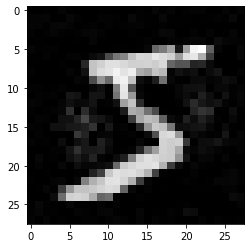

Model's Prediction for the adversarial image: 0


In [19]:
%matplotlib inline 
img = np.array(adv_example, dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

print("Model's Prediction for the adversarial image: " + str(np.argmax(model.predict(x=adv_example[:1]))))

### Configure Watson Openscale

In [10]:
WOS_CREDENTIALS = {
    "url": "",
    "username": "",
    "password": "",
    "instance_id": ""
}

### Set Up Openscale client

In [11]:
authenticator = CloudPakForDataAuthenticator(
    url=WOS_CREDENTIALS["url"],
    username=WOS_CREDENTIALS["username"],
    password=WOS_CREDENTIALS["password"],
    disable_ssl_verification=True
)

client = OpenScaleAPIClient(
    service_url=WOS_CREDENTIALS["url"],
    service_instance_id=WOS_CREDENTIALS["instance_id"],
    authenticator=authenticator
)

print(client.version)

3.0.31


### Initialize spark session

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import pandas as pd

sparkconf = SparkConf().setMaster("local[*]")
spark = SparkSession.builder.appName("TestMetricFramework").config(conf=sparkconf).getOrCreate()
spark.sparkContext._conf.getAll()

### Provide the following configuration parameters to compute Adversarial Accuracy metric. <br>

If no parameters are mentioned under Adversarial accuracy, the default HopSkipJump attack will be used for computing adversarial accuracy. <br>

- metrics_configuration: The metrics configuration parameters. <br>
    - model: A trained model. This is required only if the attack_type is whitebox.<br>
    - model_type: Type of the model, either keras, tensorflow or blackbox. <br>
    - input_data_type: The data type of the input data, ART metrics are only supported for image models. <br>
    - number_of_classes: The number of classes in the training data <br>
    - input_shape: Required for model_type `tensorflow`. shape of the training data in the form of a tuple, for example, (224, 224, 3). <br>
    - loss_object: optional parameter for tensorflow models. loss_object of type tf.keras.losses <br>
    - optimizer: optional parameter for tensorflow models. optimizer of type tf.keras.optimizers <br>
    
    - Adversarial_Accuracy: The parameters needed for computing the metric. <br>
    - Supported parameters for Adversarial_Accuracy: <br>
        - attack_budgets(Optional): perturbation sizes, as an array for the attacks to be performed. <br>
        - attack_name(Optional) : Name of the attack. Supported values are ["auto", "fgsm", "hsj"] <br>
        - attack_crafter(Optional): EvasionAttack instance to create adversarial examples. <br>
        For example, HopSkipJump(model,  {"max_iter": 30, "max_eval": 100, "init_eval": 10, "init_size": 10}) <br>
        - attack_type(Optional): Type of the attack to be performed. Supported values are "whitebox", "blackbox". Default blackbox attack will be used if no value is provided. Please note that it is mandatory to provide scoring_fn for black box attacks.<br>

Training data should be specified as part of TrainTestData object to compute adversarial accuracy metric.


In [91]:
#Set metrics plugin level configuration
from ibm_metrics_plugin.common.utils.constants import ARTMetricType, InputDataType
from ibm_metrics_plugin.common.entity.config import TrainTestData

configuration = {}
train_test_data = TrainTestData(x_train=x_train, y_train=y_train)   

configuration["configuration"] = {
                "art":{
                    "metrics_configuration":{
                        "model": model,
                        "model_type": "keras",
                        "input_data_type": InputDataType.IMAGE.value,
                        ARTMetricType.ADVERSARIAL_ACCURACY.value:{
                            "attack_type": "whitebox",
                            "max_iterations": 200, # optional parameter, max number of iterations to run the PGD attack
                            "eps_step": 0.1, # attack step size at each iteration (optional parameter) 
                            "attack_budgets": [i / 255 for i in range(1, 128, 2)]
                            }
                        
                    }
                }
            }

### Compute the Adversarial Accuracy metric for various perturbation sizes. 

In [92]:
default_model_results = client.ai_metrics.compute_metrics(spark=spark, configuration=configuration, data_frame=pd.DataFrame(), train_test_data=train_test_data)

In [93]:
adversarial_accuracies = default_model_results["metrics_result"]["art"]["adversarial_accuracy"]["accuracies"]
perturbation_sizes = default_model_results["metrics_result"]["art"]["adversarial_accuracy"]["perturbation_sizes"]

In [94]:
y_pred = model.predict(x=x_train)
benign_accuracy = np.mean(np.argmax(y_train, axis=1) == np.argmax(y_pred, axis=1)).item()
benign_accuracy

0.80145

#### Plot the adversarial accuracy as a function of attack budget(perturbation size)

(0.0, 1.05)

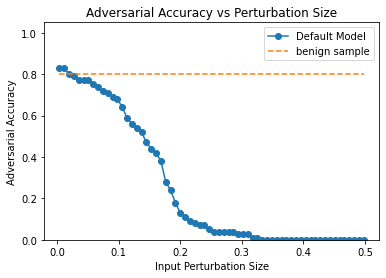

In [95]:
import matplotlib.pyplot as plt

plt.plot(perturbation_sizes, adversarial_accuracies, marker="o", label="Default Model")
plt.plot([perturbation_sizes[0], perturbation_sizes[-1]], [benign_accuracy, benign_accuracy], linestyle="--", label="benign sample")
plt.legend()
plt.title("Adversarial Accuracy vs Perturbation Size")
plt.xlabel("Input Perturbation Size")
plt.ylabel("Adversarial Accuracy")
plt.ylim([0, 1.05])

The adversarial accuracy, which is the accuracy of the model on adversarial examples, decreases as the size of the adversarial perturbations increases. A model is more robust if it achieves a higher adversarial accuracy for larger perturbations.


### Load a robust ML model and generate adversarial accuracy metrics for the robust model

In [ ]:
# Load a robust Keras model.
import wget
from keras.models import load_model

!rm mnist_cnn_robust.h5
path = wget.download('https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1', 'mnist_cnn_robust.h5')

robust_classifier_model = load_model(path)

In [97]:
configuration = {}
train_test_data = TrainTestData(x_train=x_train, y_train=y_train)   

configuration["configuration"] = {
                "art":{
                    "metrics_configuration":{
                        "model": robust_classifier_model,
                        "model_type": "keras",
                        "input_data_type": InputDataType.IMAGE.value,
                        ARTMetricType.ADVERSARIAL_ACCURACY.value:{
                            "attack_type": "whitebox",
                            "attack_budgets": [i / 255 for i in range(1, 128, 2)]
                            }
                        
                    }
                }
            }

In [ ]:
robust_model_results = client.ai_metrics.compute_metrics(spark=spark, configuration=configuration, data_frame=pd.DataFrame(), train_test_data=train_test_data)

In [99]:
robust_adversarial_accuracies = robust_model_results["metrics_result"]["art"]["adversarial_accuracy"]["accuracies"]
robust_perturbation_sizes = robust_model_results["metrics_result"]["art"]["adversarial_accuracy"]["perturbation_sizes"]
robust_benign_accuracy = np.mean(np.argmax(y_train, axis=1) == np.argmax(robust_classifier_model.predict(x_train), axis=1)).item()

#### Plot the adversarial accuracies 

(0.0, 1.05)

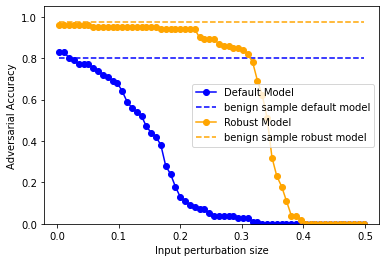

In [100]:
import matplotlib.pyplot as plt

plt.plot(perturbation_sizes, adversarial_accuracies, label="Default Model", marker="o", color="blue")
plt.plot([perturbation_sizes[0], perturbation_sizes[-1]], [benign_accuracy, benign_accuracy], linestyle="--", label="benign sample default model", color="blue")
plt.plot(robust_perturbation_sizes, robust_adversarial_accuracies, label="Robust Model", marker="o", color="orange")
plt.plot([perturbation_sizes[0], perturbation_sizes[-1]], [robust_benign_accuracy, robust_benign_accuracy], linestyle="--", label="benign sample robust model", color="orange")
plt.legend()
plt.xlabel("Input perturbation size")
plt.ylabel("Adversarial Accuracy")
plt.ylim([0, 1.05])

From the above graph, it can be noticed that the accuracy of the robust model doesn't vary much with the increase in the perturbation size of the white box atack. But beyond a point, the accuracy of the robust model also decreases with increase in the perturbation size.


### Generate adversarial accuracy using black box attacks

Define a scoring function which returns the model's prediction class. This is mandatory for black box attacks.

In [ ]:
def scoring_fn(x):
    res = to_categorical(np.argmax(model.predict(x), axis=1), 10)
    return res

In [101]:
configuration = {}
train_test_data = TrainTestData(x_train=x_train, y_train=y_train)   

configuration["configuration"] = {
                "art":{
                    "metrics_configuration":{
                        "model_type": "blackbox",
                        "input_data_type": InputDataType.IMAGE.value,
                        "number_of_classes": 10,
                        ARTMetricType.ADVERSARIAL_ACCURACY.value:{
                            "num_samples": 100,
                            "attack_type": "blackbox"
                            }
                        
                    }
                }
            }

In [102]:
black_box_results = client.ai_metrics.compute_metrics(spark=spark, configuration=configuration, data_frame=pd.DataFrame(), train_test_data=train_test_data, scoring_fn=scoring_fn)


HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
accuracies = black_box_results["metrics_result"]["art"]["adversarial_accuracy"]["accuracies"]
perturbation_sizes = black_box_results["metrics_result"]["art"]["adversarial_accuracy"]["perturbation_sizes"]

#### Plot the adversarial accuracy vs perturbation size graph

(0.0, 1.0)

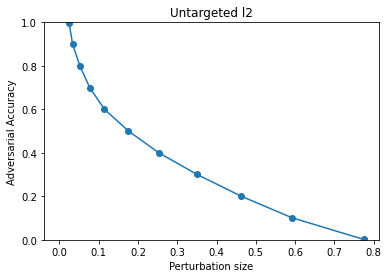

In [104]:
plt.plot(perturbation_sizes, accuracies, marker="o")

plt.xlabel("Perturbation size")
plt.ylabel("Adversarial Accuracy")
plt.title("Untargeted l2")
plt.ylim([0, 1.0])

It can be observed from the above figure that the adversarial accuracy, computed using black box attacks, reduces as the perturbation size increases.

### Compute adversarial accuracy on adversarial examples generated on top of adversarial examples

In the next cells, we will compute adversarial accuracy on adversarial examples generated on top of adversarial examples. The adversarial examples are close to the decision boundary. Therefore, creating adversarial examples on adversarial examples only requires a very small perturbation to change the prediction.
Hence, with minor change in the perturbation, there will be a huge drop in the adversarial accuracy in this case.

In [105]:
from art.attacks.evasion.hop_skip_jump import HopSkipJump
from art.estimators.classification import BlackBoxClassifier

# Create art classifier, which is a wrapper on top of the original model
art_classifier = BlackBoxClassifier(predict_fn=scoring_fn, input_shape=x_train[0].shape, 
                                            nb_classes=10, clip_values=(0, 255))

# Generate adversarial examples using the HopSkipJump black box attack
adv_examples = HopSkipJump(art_classifier).generate(x_train[:100], y=y_train)

# Create TrainTestData object with these adversarial examples
train_test_data = TrainTestData(x_train=adv_examples, y_train=None)   

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

In [106]:
# Compute the adversarial accuracies on adversarial examples
black_box_results_adversarial = client.ai_metrics.compute_metrics(spark=spark, configuration=configuration, data_frame=pd.DataFrame(), 
                                                                  train_test_data=train_test_data, scoring_fn=scoring_fn)

accuracies_adversarial = black_box_results_adversarial["metrics_result"]["art"]["adversarial_accuracy"]["accuracies"]
perturbation_sizes_adversarial = black_box_results_adversarial["metrics_result"]["art"]["adversarial_accuracy"]["perturbation_sizes"]


HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

#### Plot the adversarial accuracies vs perturbation size graph for adversarial examples

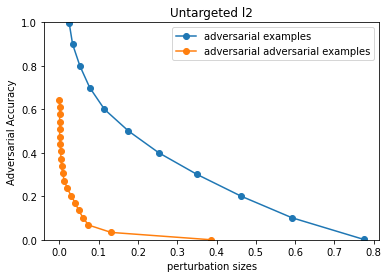

In [113]:
plt.plot(perturbation_sizes, accuracies, marker="o", label="adversarial examples")
plt.plot(perturbation_sizes_adversarial, accuracies_adversarial, marker="o", label="adversarial adversarial examples")

plt.xlabel("perturbation sizes")
plt.ylabel("Adversarial Accuracy")
plt.title("Untargeted l2")
plt.ylim([0, 1.0])
plt.legend()

The orange line in the above plot represents the adversarial accuracy vs perturbation size graph for the adversarial examples generated on adversarial examples. The adversarial accuracy quickly drops for the curve with a minimal change in perturbation size.

In the next cell, we will make a mix of adversarial examples and adversarial examples generated on these advesarial examples to simulate the case where only half of the payloads are attacked.

In [126]:
# Create TrainTestData object with a mix of adversarial examples and normal samples from the training data
mixed_sample = np.concatenate([adv_examples[:50], x_train[:50]])
train_test_data = TrainTestData(x_train=mixed_sample, y_train=None)   

# Compute the adversarial accuracies on adversarial examples
black_box_results_adversarial = client.ai_metrics.compute_metrics(spark=spark, configuration=configuration, data_frame=pd.DataFrame(), 
                                                                  train_test_data=train_test_data, scoring_fn=scoring_fn)

accuracies_mixed = black_box_results_adversarial["metrics_result"]["art"]["adversarial_accuracy"]["accuracies"]
perturbation_sizes_mixed = black_box_results_adversarial["metrics_result"]["art"]["adversarial_accuracy"]["perturbation_sizes"]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 1.05)

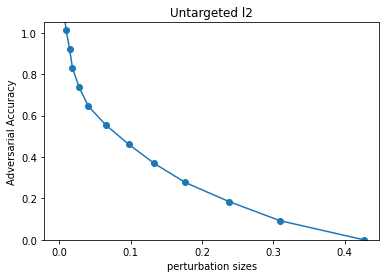

23/09/30 12:52:00 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 6480341 ms exceeds timeout 120000 ms
23/09/30 12:52:00 WARN SparkContext: Killing executors is not supported by current scheduler.


In [127]:
plt.plot(perturbation_sizes_mixed, accuracies_mixed, marker="o")

plt.xlabel("perturbation sizes")
plt.ylabel("Adversarial Accuracy")
plt.title("Untargeted l2")
plt.ylim([0, 1.05])

As per the above plot, it can be observed that the bigger the initial drop in accuracy, the bigger the adversarial examples in the payload.

Authors: Beat Buesser (beat.buesser@ibm.com), Neelima R Gade (neelgade@in.ibm.com)